### Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
import os
from pathlib import Path
from shutil import copyfile
from tqdm.notebook import tqdm

### Initialize

In [ ]:
os.chdir("..")

In [4]:
random.seed(42)

### Utility Functions

In [14]:
def show_image(image: np.ndarray, figsize: tuple = (6, 4)):
    if image is None:
        print("Error: Cannot load image. Please check the file path.")
    else:
        print(f"Image loaded successfully. Shape: {image.shape}")

    plt.figure(figsize = figsize)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [ ]:
def draw_annotation(image: np.ndarray, annotations: list):
    annotated_image = image.copy()

    for annotation in annotations:
        bbox = annotation["bbox"]
        class_id = annotation["class_id"]

        x, y, w, h = map(int, bbox)
        x0, y0 = x, y
        x1, y1 = x + w, y + h

        cv2.rectangle(annotated_image, (x0, y0), (x1, y1), (0, 255, 0), 2)
        cv2.putText(annotated_image, str(class_id), (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    
    return annotated_image

### Annotation

#### Utility Functions

In [6]:
def get_dataset_annotations(data: dict) -> dict:
    images = data["images"]
    annotations = data["annotations"]

    dataset_annotations = {}

    for image in tqdm(images, desc = "Processing image annotations", unit = "image", ncols = 1000):
        filename = image["file_name"]
        image_id = image["id"]
        width = image["width"]
        height = image["height"]

        image_data = {
            "filename": filename,
            "width": width,
            "height": height,
        }

        dataset_annotations[image_id] = {
            "image": image_data,
            "objects": []
        }

        for annotation in annotations:
            if annotation["image_id"] != image_id:
                continue

            class_id = annotation["category_id"]
            bbox = annotation["bbox"]
            object_data = {
                "class_id": class_id,
                "bbox": bbox,
            }

            dataset_annotations[image_id]["objects"].append(object_data)

    return dataset_annotations

In [7]:
def get_dataset_information(dataset: list | dict) -> dict:
    dataset_info = {}

    if type(dataset) is dict:
        dataset = list(dataset.values())

    total_images = len(dataset)
    total_annotations = sum(len(item["objects"]) for item in dataset)
    annotated_image_count = sum(1 for item in dataset if len(item["objects"]) > 0)
    unannotated_image_count = total_images - annotated_image_count

    dataset_info["total_images"] = total_images
    dataset_info["total_annotations"] = total_annotations
    dataset_info["annotated_image_count"] = annotated_image_count
    dataset_info["unannotated_image_count"] = unannotated_image_count

    return dataset_info

#### Main

In [8]:
annotation_dir = Path("annotations")
test_path = annotation_dir / "test.json"
train_path = annotation_dir / "train.json"

In [9]:
with open(test_path, mode = "r", encoding = "utf-8") as f:
    test_data = json.load(f)

In [10]:
test_annotations = get_dataset_annotations(test_data)

Processing image annotations:   0%|                                                                           …

In [11]:
get_dataset_information(test_annotations)

{'total_images': 47573,
 'total_annotations': 23382,
 'annotated_image_count': 18220,
 'unannotated_image_count': 29353}

In [12]:
with open(train_path, mode = "r", encoding = "utf-8") as f:
    train_data = json.load(f)

In [13]:
train_annotations = get_dataset_annotations(train_data)

Processing image annotations:   0%|                                                                           …

In [14]:
get_dataset_information(train_annotations)

{'total_images': 76913,
 'total_annotations': 39708,
 'annotated_image_count': 29454,
 'unannotated_image_count': 47459}

In [15]:
all_annotations = {**test_annotations, **train_annotations}

In [16]:
get_dataset_information(all_annotations)

{'total_images': 76913,
 'total_annotations': 39708,
 'annotated_image_count': 29454,
 'unannotated_image_count': 47459}

### Split Dataset

#### Utility Functions

In [17]:
def undersample(
        split_set: list,
        total_ratio: float = None,
        total_size: int = None,
        null_ratio: float = None,

) -> list:

    if total_ratio is None and total_size is None:
        raise ValueError("You must specify either 'total_ratio' or 'total_size'.")
    
    if total_ratio is not None and total_size is not None:
        raise ValueError("Specify only one of 'total_ratio' or 'total_size', not both.")

    random.shuffle(split_set)
    
    if total_ratio:
        total_size = int(len(split_set) * total_ratio)

    if null_ratio is not None:
        null_set = [item for item in split_set if len(item["objects"]) == 0]
        pos_set = [item for item in split_set if len(item["objects"]) > 0]
        
        null_size = int(total_size * null_ratio)
        pos_size = total_size - null_size
        
        sampled_set = pos_set[:pos_size] + null_set[:null_size]

    else:
        sampled_set = split_set[:total_size]
    
    return sampled_set

In [18]:
def split_dataset(split_set: list, first_ratio: float = None, first_size: int = None) -> tuple:
    if first_ratio is None and first_size is None:
        raise ValueError("You must specify either 'first_ratio' or 'first_size'.")
    
    if first_ratio is not None and first_size is not None:
        raise ValueError("Specify only one of 'first_ratio' or 'first_size', not both.")
    
    random.shuffle(split_set)
    
    if first_ratio:
        first_size = int(len(split_set) * first_ratio)

    first_split = split_set[:first_size]
    second_split = split_set[first_size:]

    return first_split, second_split

In [19]:
def get_class_distribution(split_set: list) -> dict:
    class_distribution = {}
    total_annotations = 0

    for item in split_set:
        for annotation in item["objects"]:
            class_id = annotation["class_id"]
            
            if class_id not in class_distribution:
                class_distribution[class_id] = {"count": 1}
            else:
                class_distribution[class_id]["count"] += 1
    
            total_annotations += 1

    for info in class_distribution.values():
        info["percentage"] = f"{info['count'] / total_annotations * 100:.2f}%"
    
    class_distribution = dict(sorted(class_distribution.items()))
    
    return class_distribution

In [20]:
def normalize_bbox(bbox: list, image_width: int, image_height: int) -> list:
    x, y, w, h = bbox
    
    x_center = (x + w / 2) / image_width
    y_center = (y + h / 2) / image_height
    w_norm = w / image_width
    h_norm = h / image_height

    normalized_bbox = [x_center, y_center, w_norm, h_norm]

    return normalized_bbox

In [49]:
def create_dataset(source_dir: str, dest_dir: str, training_set: list, validation_set: list, testing_set: list) -> None:
    source_dir = Path(source_dir)
    dataset_dir = Path(dest_dir)
    images_dir = dataset_dir / "images"
    labels_dir = dataset_dir / "labels"

    splits = [
        ("train", training_set),
        ("val", validation_set),
        ("test", testing_set),
    ]

    for split_name, split_set in splits:
        split_images_dir = images_dir / split_name
        split_labels_dir = labels_dir / split_name

        split_images_dir.mkdir(parents = True, exist_ok = True)
        split_labels_dir.mkdir(parents = True, exist_ok = True)

        for item in tqdm(split_set, desc = f"Creating {split_name} set", unit = "image", ncols = 1000):
            filename = item["image"]["filename"]

            source_image_path = source_dir / filename
            dest_image_path = split_images_dir / filename

            copyfile(source_image_path, dest_image_path)

            label_filename = Path(filename).with_suffix(".txt").name
            label_path = split_labels_dir / label_filename

            with open(label_path, mode = "w", encoding = "utf-8") as f:
                image_width = item["image"]["width"]
                image_height = item["image"]["height"]

                for annotation in item["objects"]:
                    class_id = annotation["class_id"]
                    bbox = annotation["bbox"]
                    bbox = normalize_bbox(bbox, image_width, image_height)
                    bbox_str = " ".join(map(str, bbox))

                    f.write(f"{class_id - 1} {bbox_str}\n")

#### Split Training Set, Validation Set, and Testing Set

In [21]:
training_set = list(train_annotations.values())
training_set = undersample(training_set, total_size = 40000, null_ratio = 0.3)

training_set, validation_set = split_dataset(training_set, first_size = 35000)

print(f"Training set size: {len(training_set)}")
print(f"Validation set size: {len(validation_set)}")

Training set size: 35000
Validation set size: 5000


In [22]:
testing_set = list(test_annotations.values())
testing_set = undersample(testing_set, total_size = 5000)

print(f"Testing set size: {len(testing_set)}")

Testing set size: 5000


In [32]:
all_dataset = list(all_annotations.values())

all_dataset_info = get_dataset_information(all_dataset)
training_set_info = get_dataset_information(training_set)
validation_set_info = get_dataset_information(validation_set)
testing_set_info = get_dataset_information(testing_set)

data = {
    "all": all_dataset_info,
    "train": training_set_info,
    "val": validation_set_info,
    "test": testing_set_info,
}

info_df = pd.DataFrame(data).T

In [33]:
info_df

,total_images,total_annotations,annotated_image_count,unannotated_image_count
all,76913,39708,29454,47459
train,35000,33067,24513,10487
val,5000,4732,3487,1513
test,5000,2443,1895,3105


In [46]:
all_dataset_dist = get_class_distribution(all_dataset)
training_set_dist = get_class_distribution(training_set)
validation_set_dist = get_class_distribution(validation_set)
testing_set_dist = get_class_distribution(testing_set)

class_index = [f"{category['id'] - 1} {category['name']}" for category in train_data["categories"]]

count_data = {
    "all": [class_dist["count"] for class_dist in all_dataset_dist.values()],
    "train": [class_dist["count"] for class_dist in training_set_dist.values()],
    "val": [class_dist["count"] for class_dist in validation_set_dist.values()],
    "test": [class_dist["count"] for class_dist in testing_set_dist.values()],
}
count_df = pd.DataFrame(count_data, index = class_index).T

percentage_data = {
    "all": [class_dist["percentage"] for class_dist in all_dataset_dist.values()],
    "train": [class_dist["percentage"] for class_dist in training_set_dist.values()],
    "val": [class_dist["percentage"] for class_dist in validation_set_dist.values()],
    "test": [class_dist["percentage"] for class_dist in testing_set_dist.values()],
}
percentage_df = pd.DataFrame(percentage_data, index = class_index).T

In [47]:
count_df

,0 Baton,1 Pliers,2 Hammer,3 Powerbank,4 Scissors,5 Wrench,6 Gun,7 Bullet,8 Sprayer,9 HandCuffs,10 Knife,11 Lighter
all,1513,4236,3546,5171,4352,4350,2178,1837,2970,2096,3290,4169
train,1268,3576,2960,4288,3581,3638,1809,1542,2469,1767,2709,3460
val,170,478,420,624,536,518,265,210,358,233,418,502
test,86,272,270,311,293,226,165,130,116,139,237,198


In [48]:
percentage_df

,0 Baton,1 Pliers,2 Hammer,3 Powerbank,4 Scissors,5 Wrench,6 Gun,7 Bullet,8 Sprayer,9 HandCuffs,10 Knife,11 Lighter
all,3.81%,10.67%,8.93%,13.02%,10.96%,10.95%,5.49%,4.63%,7.48%,5.28%,8.29%,10.50%
train,3.83%,10.81%,8.95%,12.97%,10.83%,11.00%,5.47%,4.66%,7.47%,5.34%,8.19%,10.46%
val,3.59%,10.10%,8.88%,13.19%,11.33%,10.95%,5.60%,4.44%,7.57%,4.92%,8.83%,10.61%
test,3.52%,11.13%,11.05%,12.73%,11.99%,9.25%,6.75%,5.32%,4.75%,5.69%,9.70%,8.10%


![Label statistics](https://github.com/lutao2021/PIDray/blob/main/docs/label_statistics.jpg?raw=true)

#### Sample

Image loaded successfully. Shape: (448, 400, 3)


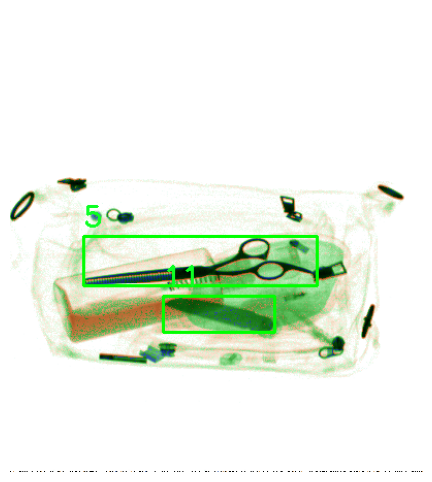

In [39]:
sample = cv2.imread("all/xray_20377.png")
annotations = training_set[3]["objects"]
annotated_image = draw_annotation(sample, annotations)

show_image(annotated_image, figsize = (8, 6))

#### Create Dataset

In [50]:
create_dataset(
    source_dir = "all",
    dest_dir = "dataset",
    training_set = training_set,
    validation_set = validation_set,
    testing_set = testing_set,
)

Creating train set:   0%|                                                                                     …

Creating val set:   0%|                                                                                       …

Creating test set:   0%|                                                                                      …

### Rename

#### Utility Functions

In [51]:
def rename_files(images_dir: str, labels_dir: str) -> None:
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    for split in ["train", "val", "test"]:
        split_images_dir = images_dir / split
        split_labels_dir = labels_dir / split

        image_paths = sorted(list(split_images_dir.iterdir()))

        easy_count, hard_count, hidden_count = 0, 0, 0

        for idx, image_path in enumerate(tqdm(image_paths, desc = f"Renaming files in {split} set", unit = "file", ncols = 1000)):
            label_filename = image_path.with_suffix(".txt").name
            label_path = split_labels_dir / label_filename

            if "easy" in image_path.name:
                new_name = f"xray_easy_{easy_count:05d}"
                easy_count += 1
            elif "hard" in image_path.name:
                new_name = f"xray_hard_{hard_count:05d}"
                hard_count += 1
            elif "hidden" in image_path.name:
                new_name = f"xray_hidden_{hidden_count:05d}"
                hidden_count += 1
            else:
                new_name = f"xray_{idx:05d}"

            new_label_filename = new_name + ".txt"
            new_label_path = split_labels_dir / new_label_filename

            label_path.rename(new_label_path)

            new_filename = new_name + ".png"
            new_image_path = split_images_dir / new_filename

            image_path.rename(new_image_path)

#### Main

In [52]:
rename_files(
    images_dir = "dataset/images",
    labels_dir = "dataset/labels",
)

Renaming files in train set:   0%|                                                                            …

Renaming files in val set:   0%|                                                                              …

Renaming files in test set:   0%|                                                                             …